In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("/content/output.csv")
dt = data.drop(data.columns[10:24], axis=1)  # drop Sun.- Sat. open/close times
# possibly also drop "full_address" etc. need to discuss

# New Section

In [8]:
# filter dataset: only keep restaurants
dt_restaurant = dt[dt['Is_Restaurants'] == 1]
# reverse the dummy variables (restaurant types) into one category 
rest_types = dt_restaurant[['business_id','Sandwiches', 'Fast Food',
       'Nightlife', 'Pizza', 'Bars', 'Mexican', 'Food',
       'American (Traditional)', 'Burgers', 'Chinese', 'Italian',
       'American (New)', 'Breakfast & Brunch', 'Thai', 'Indian', 'Sushi Bars',
       'Korean', 'Mediterranean', 'Japanese', 'Seafood', 'Middle Eastern',
       'Pakistani', 'Barbeque', 'Vietnamese', 'Asian Fusion', 'Diners',
       'Greek', 'Vegetarian']]
rest_types = rest_types.set_index('business_id')
rest_types["dummy_sum"] = rest_types.sum(axis=1)
dummy_type = rest_types[rest_types.dummy_sum == 1]
dummy_type = dummy_type.drop('dummy_sum',axis = 1)
dummy_type['type'] = dummy_type.idxmax(1)
business_type = dummy_type['type']

In [9]:
# new_dt is the restaurant dataset with restaurant type (dummy variables are dropped)
new_dt = pd.merge(dt_restaurant, business_type, left_on='business_id', right_index=True, how='left')
type_cols = ['Sandwiches', 'Fast Food',
       'Nightlife', 'Pizza', 'Bars', 'Mexican', 'Food',
       'American (Traditional)', 'Burgers', 'Chinese', 'Italian',
       'American (New)', 'Breakfast & Brunch', 'Thai', 'Indian', 'Sushi Bars',
       'Korean', 'Mediterranean', 'Japanese', 'Seafood', 'Middle Eastern',
       'Pakistani', 'Barbeque', 'Vietnamese', 'Asian Fusion', 'Diners',
       'Greek', 'Vegetarian']
new_dt = new_dt.drop(type_cols, axis =1)
# new_dt.iloc[:,-1:] the newly added column is called 'type_y'

In [16]:
# Create binary variable of restaurant stars
bi_data = new_dt.copy()
bi_data['Class'] = bi_data.apply(lambda x: 1 if x['stars']>3.5 else 0, axis=1)
bi_data.head()

,business_id,city,full_address,latitude,longitude,name,review_count,stars,state,type_x,Noise Level,Attire,Alcohol,Price_Range,Delivery,Outdoor_Seating,Drive-Thru,Good_for_Groups,Has_TV,Caters,Waiter_Service,Good_for_Kids,Accepts_Credit_Cards,Takes_Reservations,Wi_Fi,Happy_Hour,Good_for_Dancing,Smoking,BYOB,Corkage,Take_Out,Coat_Check,Parking_Street,Parking_Valet,Parking_Lot,Parking_Garage,Parking_Validated,Music_DJ,Music_Karaoke,Music_Video,Music_Live,Music_Jukebox,Music_Background_Music,Is_Restaurants,Number_of_Checkins,Number_of_Tips,Number_of_Tip_Likes,type_y,Class
0,4bEjOyTaDG24SY5TxsaUNQ,Las Vegas,"3655 Las Vegas Blvd S The Strip Las Vegas, NV ...",36.112952,-115.172589,Mon Ami Gabi,5642,4.0,NV,business,average,casual,full_bar,2.0,0.0,1.0,NaN,1.0,0.0,0.0,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,0.0,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,11390,745,11,Breakfast & Brunch,1
1,zt1TpTuJ6y9n551sw9TaEg,Las Vegas,The Cosmopolitan of Las Vegas 3708 Las Vegas B...,36.109876,-115.175164,Wicked Spoon,4558,3.5,NV,business,average,casual,full_bar,3.0,0.0,0.0,NaN,1.0,0.0,0.0,1.0,1.0,1.0,0.0,no,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,13342,1019,15,NaN,0
2,2e2e7WgqU1BnpxmQL5jbfw,Las Vegas,Planet Hollywood Resort & Casino 3667 Las Vega...,36.109930,-115.170862,Earl of Sandwich,4452,4.5,NV,business,average,casual,beer_and_wine,1.0,0.0,0.0,NaN,1.0,1.0,1.0,0.0,1.0,1.0,0.0,free,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,16641,1148,7,Sandwiches,1
3,sIyHTizqAiGu12XMLX3N3g,Las Vegas,Caesars Palace Las Vegas Hotel & Casino 3570 L...,36.115854,-115.176174,Bacchanal Buffet,4390,4.0,NV,business,average,casual,full_bar,3.0,0.0,0.0,NaN,1.0,0.0,0.0,1.0,1.0,1.0,0.0,no,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,15078,723,23,NaN,1
4,aGbjLWzcrnEx2ZmMCFm3EA,Las Vegas,Planet Hollywood Las Vegas Resort & Casino 366...,36.110108,-115.172338,Gordon Ramsay BurGR,3811,4.0,NV,business,loud,casual,full_bar,2.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,no,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,9142,527,13,Burgers,1


# Classification model

In [63]:
drop_cols = ['business_id','full_address','latitude', 'longitude', 'name', 'review_count', 'city', 'state', 'type', 'Number_of_Checkins', 'Number_of_Tips', 'Number_of_Tip_Likes']
model_dt = dt_restaurant.drop(drop_cols, axis = 1)

In [64]:
cat2num = {"Attire": {"casual": 1, "dressy": 2, 'formal': 3},
           "Noise Level": {'average':3, 'loud':2, 'very_loud':1, 'quiet':4 },
           "Alcohol": {'full_bar': 2, 'beer_and_wine': 3, 'none': 1},
           "Wi_Fi": {'no': 1, 'free':3, 'paid':2},
           "Smoking": {'no':1, 'yes':2, 'outdoor':3}}
model_dt.replace(cat2num, inplace=True)

In [ ]:
dropna_dt = model_dt.fillna(0)
dropna_dt.head()

In [76]:
for col in dropna_dt.columns:
    dropna_dt[col] = dropna_dt[col].astype('int')

In [78]:
corr_matrix = dropna_dt.corr()
corr_matrix['stars'].sort_values(ascending=False)

stars                     1.000000
Noise Level               0.160229
Caters                    0.155872
Alcohol                   0.144069
Takes_Reservations        0.142434
                            ...   
American (Traditional)   -0.048606
Burgers                  -0.164668
Fast Food                -0.227457
Drive-Thru               -0.230847
Is_Restaurants                 NaN
Name: stars, Length: 63, dtype: float64

## Split the data

In [79]:
from sklearn.model_selection import train_test_split
X = dropna_dt.drop('stars', axis = 1)
y = dropna_dt['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## DecisionTree

In [80]:
import numpy as np 
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

tree_clf = DecisionTreeClassifier(max_depth=4,random_state=42)

tree_clf.fit(X_train, y_train)
pred = tree_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
accuracy

0.479171863307558

# Histogram showing the distribution of review stars

Text(0, 0.5, 'Number')

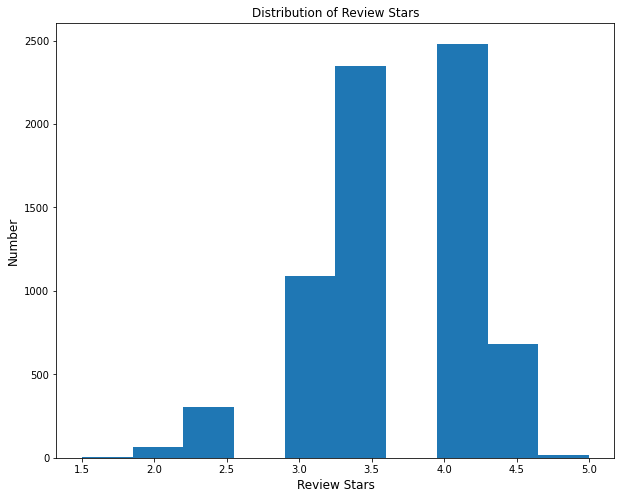

In [ ]:
# Histogram showing the distribution of review stars
plt.figure(figsize=[10, 8])
plt.hist(new_dt["stars"])
plt.title("Distribution of Review Stars", fontsize = 12)
plt.xlabel("Review Stars", fontsize = 12)
plt.ylabel("Number", fontsize = 12)

In [ ]:
import seaborn as sns
sns.boxplot(x="state", y="stars", data=new_dt,ax=ax)

NameError: ignored

# Part 2: Important Feature: review stars

### distribution of stars

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


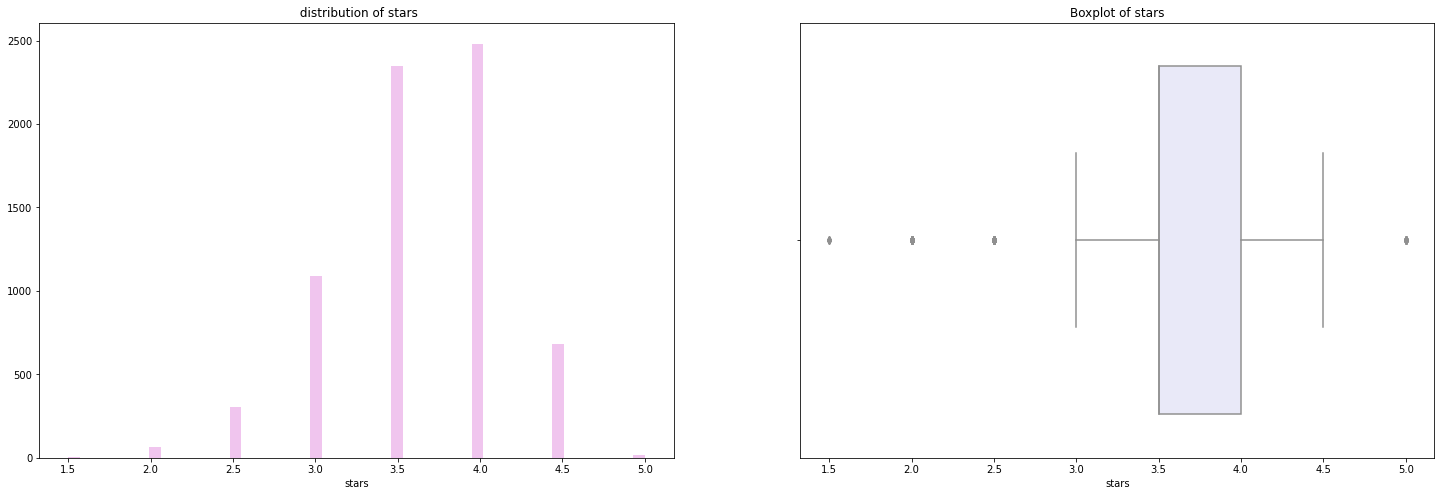

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(25,8))
stars_count=new_dt.stars.value_counts()
sns.distplot(new_dt.stars, kde=False,color='orchid',ax=ax[0])
sns.boxplot(x=new_dt.stars,color='lavender',ax=ax[1])
ax[0].set_title(' distribution of stars')
ax[1].set_title('Boxplot of stars')
plt.show()

### distribution of review stars in each state

####1.all the state

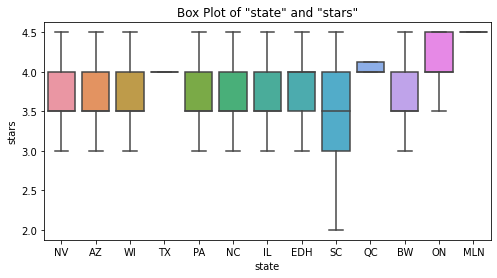

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x='state',y='stars',data = new_dt, showfliers=False)
plt.title('Box Plot of "state" and "stars"')
plt.show()

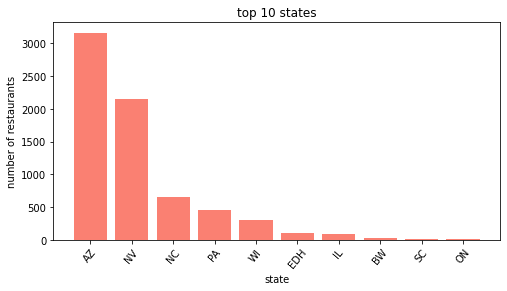

In [ ]:
state10=new_dt.state.value_counts().index[0:10]
plt.figure(figsize=(8,4))
plt.bar(state10,new_dt.state.value_counts().values[0:10],color='salmon')
plt.xticks(rotation=50)
plt.xlabel('state')
plt.ylabel('number of restaurants')
plt.title('top 10 states')
plt.show()

#### 2.AZ 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


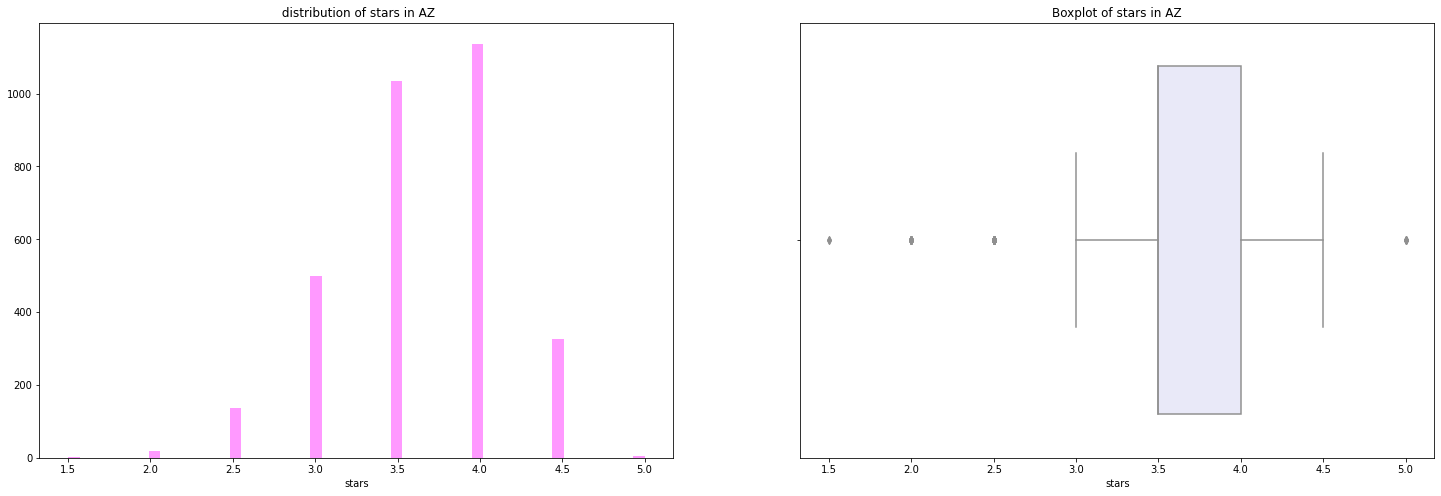

In [ ]:
AZ=new_dt[new_dt.state=='AZ']
fig, ax = plt.subplots(1,2,figsize=(25,8))
sns.distplot(AZ.stars, kde=False,color='magenta',ax=ax[0])
sns.boxplot(x=AZ.stars,color='lavender',ax=ax[1])
ax[0].set_title(' distribution of stars in AZ')
ax[1].set_title('Boxplot of stars in AZ')
plt.show()

#### 3.NV 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


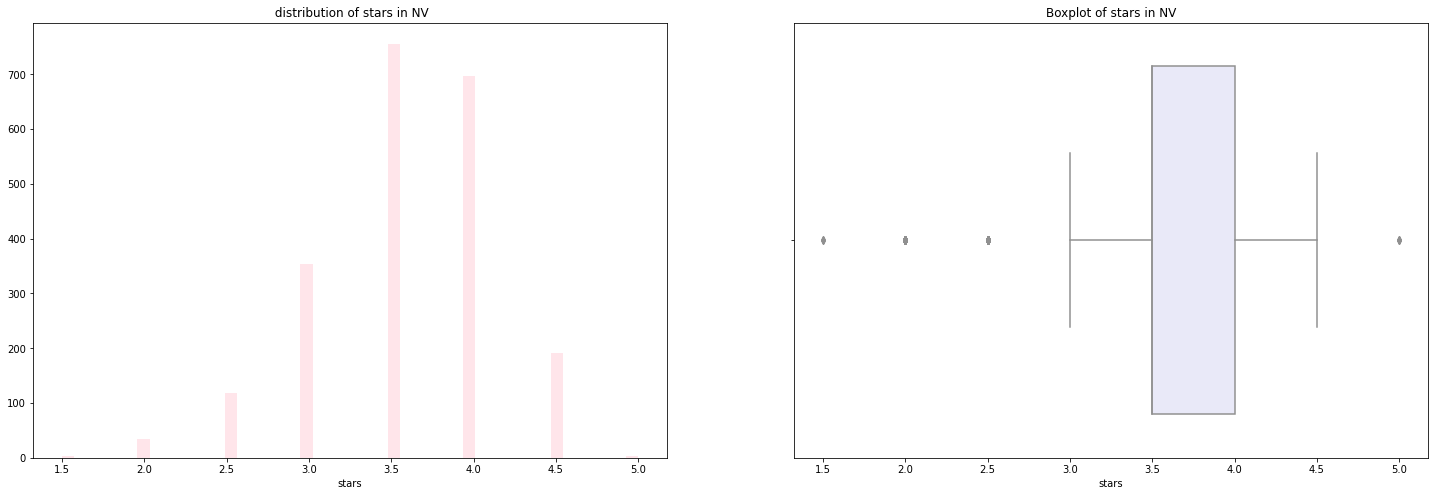

In [ ]:
NV=new_dt[new_dt.state=='NV']
fig, ax = plt.subplots(1,2,figsize=(25,8))
sns.distplot(NV.stars, kde=False,color='pink',ax=ax[0])
sns.boxplot(x=NV.stars,color='lavender',ax=ax[1])
ax[0].set_title(' distribution of stars in NV')
ax[1].set_title('Boxplot of stars in NV')
plt.show()

### distribution of review stars in each city

95


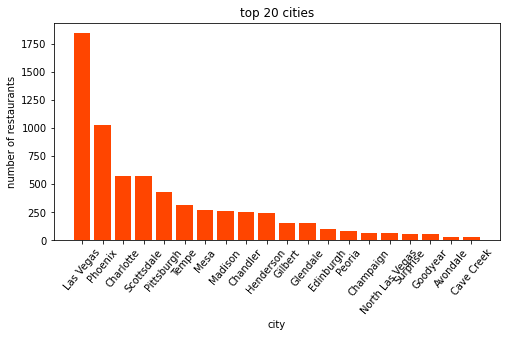

In [ ]:
# 260 cities and pick the top 20 
numer_of_city=new_dt.city.nunique()
print(numer_of_city)
city20=new_dt.city.value_counts().index[0:20]
new_dt_city=new_dt[new_dt.city.isin (city20.values)]
plt.figure(figsize=(8,4))
plt.bar(city20,new_dt.city.value_counts().values[0:20],color='orangered')
plt.xticks(rotation=50)
plt.xlabel('city')
plt.ylabel('number of restaurants')
plt.title('top 20 cities')
plt.show()

#### 1.top20 the cities

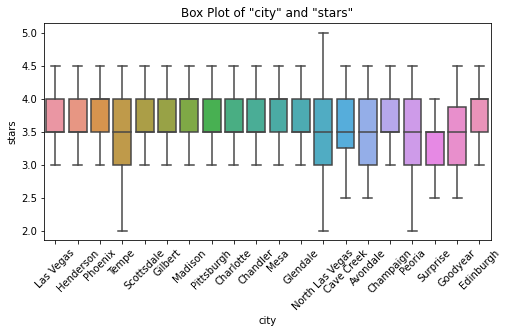

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x='city',y='stars',data = new_dt_city, showfliers=False)
plt.title('Box Plot of "city" and "stars"')
plt.xticks(rotation=45)
plt.show()

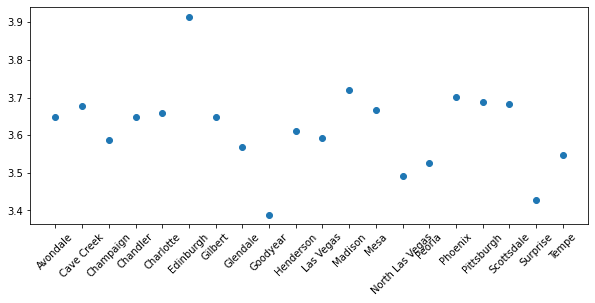

In [ ]:
#top20 cities mean stars
group_city=new_dt_city.groupby('city')['stars'].mean()
fig, ax = plt.subplots(figsize=(10,4))
plt.scatter(group_city.index,group_city.values)
plt.xticks(rotation=45)
plt.show()

#### 2.Las Vegas 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


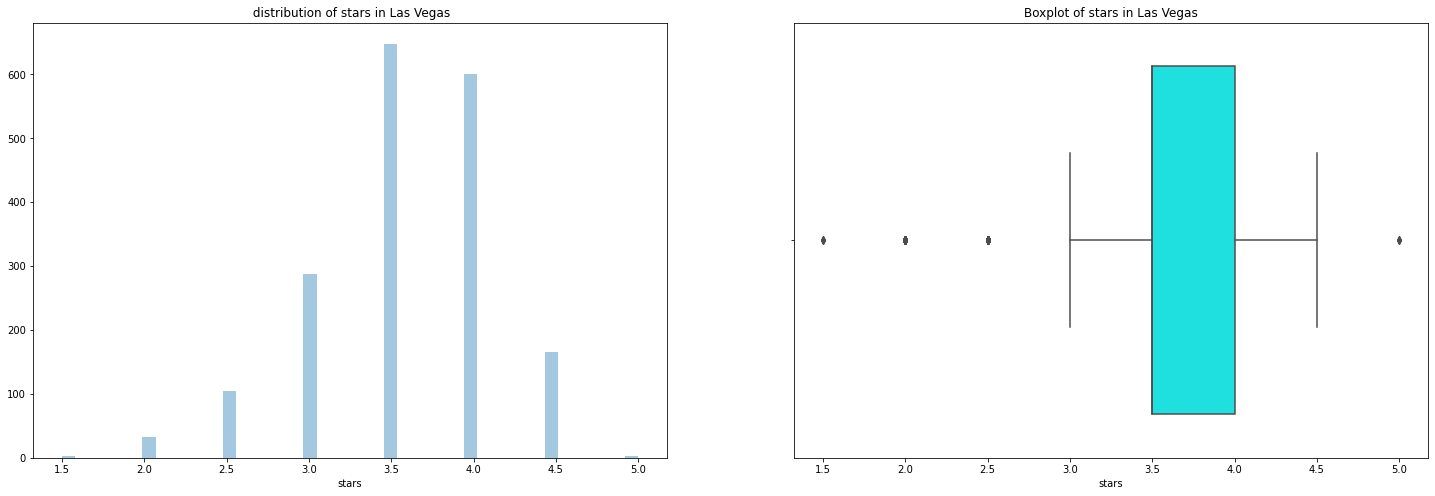

In [ ]:
Las_Vegas=new_dt[new_dt.city=='Las Vegas']
fig, ax = plt.subplots(1,2,figsize=(25,8))
sns.distplot(Las_Vegas.stars, kde=False,ax=ax[0])
sns.boxplot(x=Las_Vegas.stars,color='cyan',ax=ax[1])
ax[0].set_title(' distribution of stars in Las Vegas')
ax[1].set_title('Boxplot of stars in Las Vegas')
plt.show()

#### 3.Phoenix

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


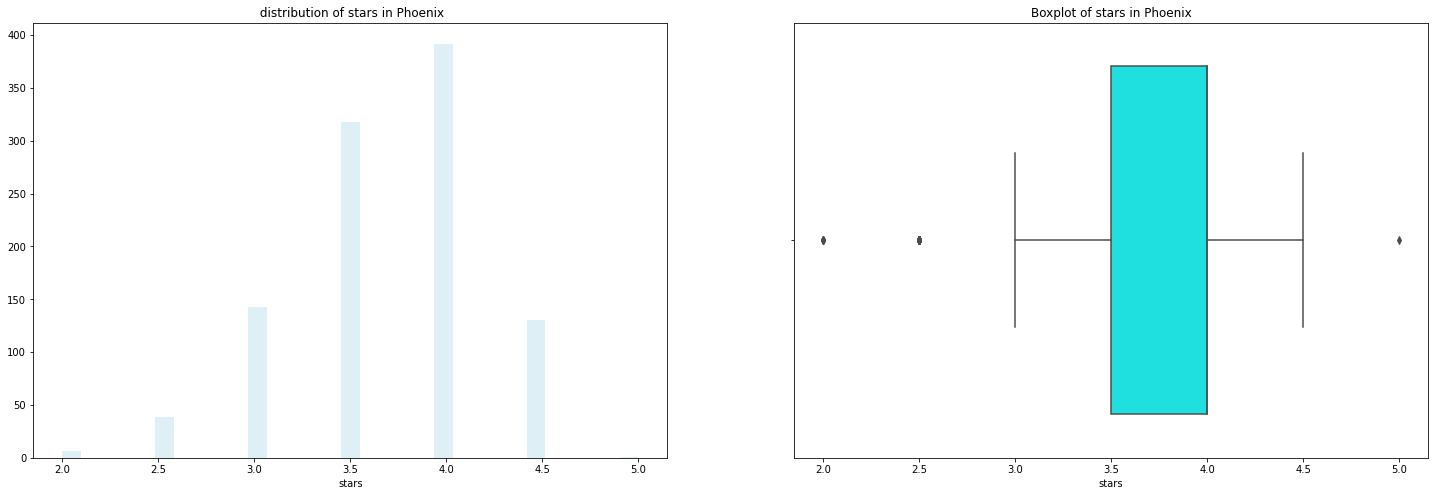

In [ ]:
Phoenix=new_dt[new_dt.city=='Phoenix']
fig, ax = plt.subplots(1,2,figsize=(25,8))
sns.distplot(Phoenix.stars, color='lightblue',kde=False,ax=ax[0])
sns.boxplot(x=Phoenix.stars,color='cyan',ax=ax[1])
ax[0].set_title(' distribution of stars in Phoenix')
ax[1].set_title('Boxplot of stars in Phoenix')
plt.show()

### price vs review stars

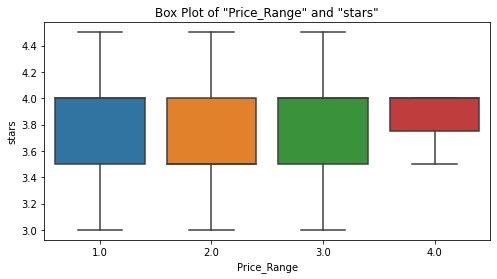

In [ ]:
price_range=new_dt.Price_Range.value_counts()
plt.figure(figsize=(8,4))
sns.boxplot(x='Price_Range',y='stars',data = new_dt_city, showfliers=False)
plt.title('Box Plot of "Price_Range" and "stars"')
plt.show()

#### 1.price_range =2

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


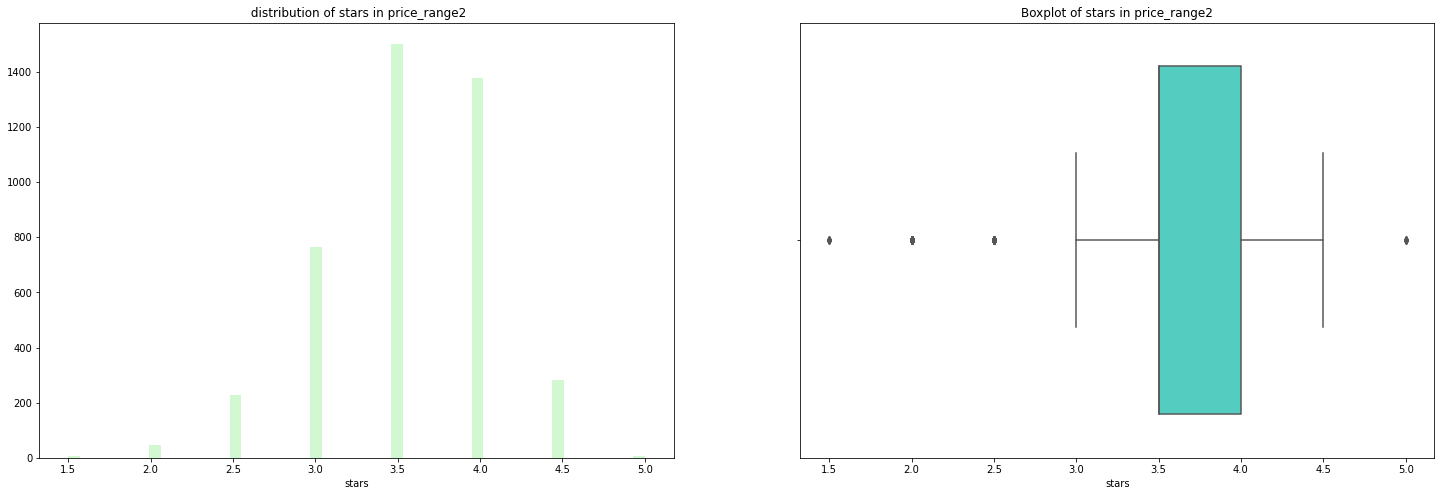

In [ ]:
price_range2=new_dt[new_dt.Price_Range==2.0]
fig, ax = plt.subplots(1,2,figsize=(25,8))
sns.distplot(price_range2.stars, color='lightgreen',kde=False,ax=ax[0])
sns.boxplot(x=price_range2.stars,color='turquoise',ax=ax[1])
ax[0].set_title(' distribution of stars in price_range2')
ax[1].set_title('Boxplot of stars in price_range2')
plt.show()

#### 2.price_range =3

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


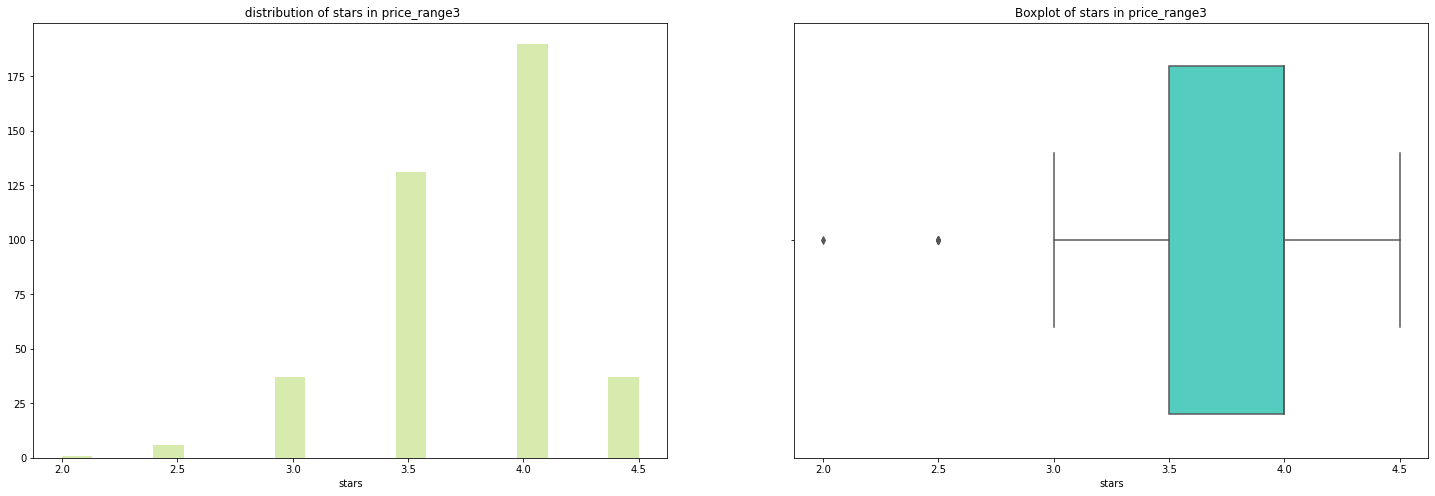

In [ ]:
price_range3=new_dt[new_dt.Price_Range==3.0]
fig, ax = plt.subplots(1,2,figsize=(25,8))
sns.distplot(price_range3.stars, color='yellowgreen',kde=False,ax=ax[0])
sns.boxplot(x=price_range3.stars,color='turquoise',ax=ax[1])
ax[0].set_title(' distribution of stars in price_range3')
ax[1].set_title('Boxplot of stars in price_range3')
plt.show()

### parking vs review stars  eg:street parking or valet parking

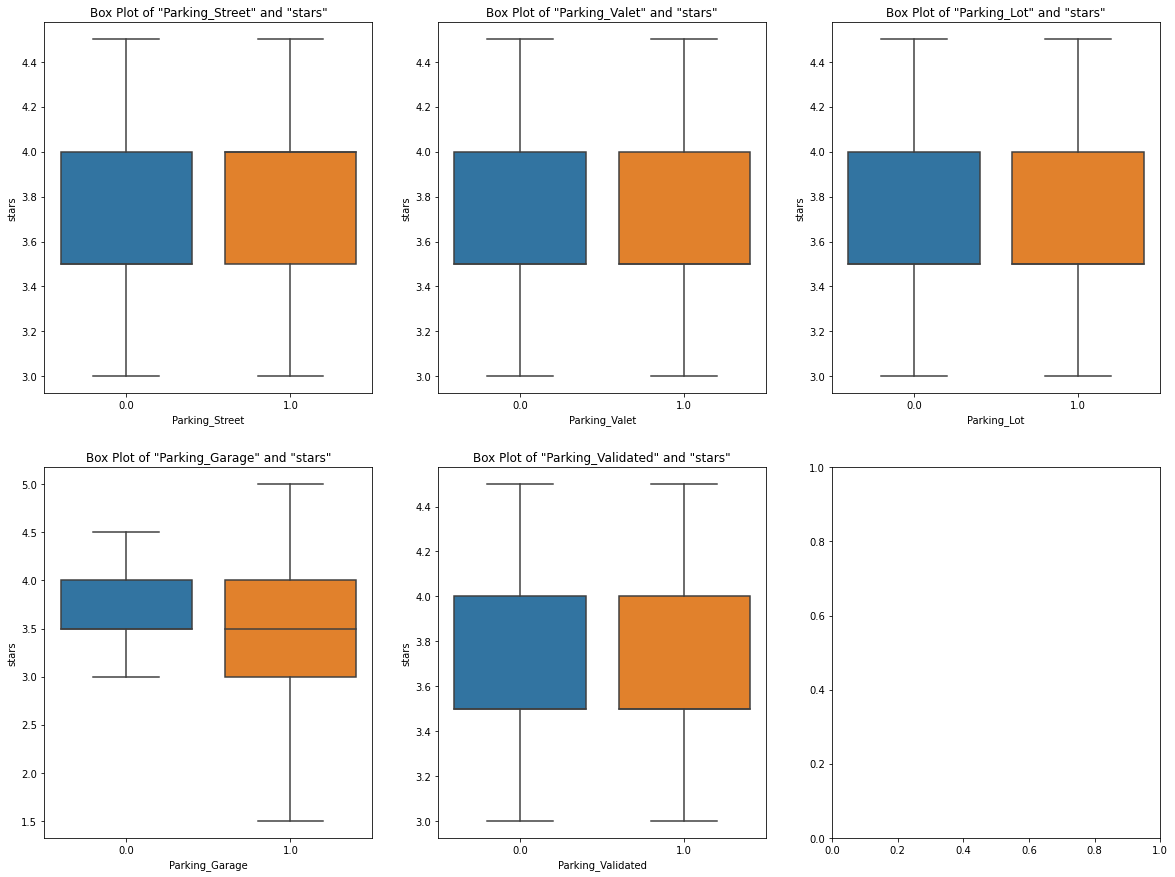

In [ ]:
price_range=new_dt.Price_Range.value_counts()
fig, ax = plt.subplots(2,3,figsize=(20,15))
sns.boxplot(x='Parking_Street',y='stars',data = new_dt, showfliers=False,ax=ax[0,0])
sns.boxplot(x='Parking_Valet',y='stars',data = new_dt, showfliers=False,ax=ax[0,1])
sns.boxplot(x='Parking_Lot',y='stars',data = new_dt, showfliers=False,ax=ax[0,2])
sns.boxplot(x='Parking_Garage',y='stars',data = new_dt, showfliers=False,ax=ax[1,0])
sns.boxplot(x='Parking_Validated',y='stars',data = new_dt, showfliers=False,ax=ax[1,1])
ax[0,0].set_title('Box Plot of "Parking_Street" and "stars"')
ax[0,1].set_title('Box Plot of "Parking_Valet" and "stars"')
ax[0,2].set_title('Box Plot of "Parking_Lot" and "stars"')
ax[1,0].set_title('Box Plot of "Parking_Garage" and "stars"')
ax[1,1].set_title('Box Plot of "Parking_Validated" and "stars"')
plt.show()

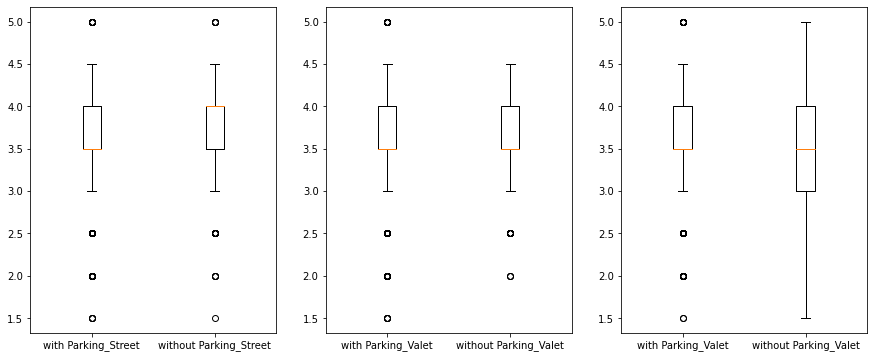

In [ ]:
plt.figure(figsize=(15,6))
label1 = 'with Parking_Street','without Parking_Street'
label2 = 'with Parking_Valet','without Parking_Valet'
label3 = 'with Parking_Garage','without Parking_Garage'
plt.subplot(1,3,1)
plt.boxplot([new_dt[new_dt.Parking_Street==0.0]['stars'], new_dt[new_dt.Parking_Street==1.0]['stars']], labels = label1)
plt.subplot(1,3,2)
plt.boxplot([new_dt[new_dt.Parking_Valet==0.0]['stars'], new_dt[new_dt.Parking_Valet==1.0]['stars']], labels = label2)
plt.subplot(1,3,3)
plt.boxplot([new_dt[new_dt.Parking_Garage==0.0]['stars'], new_dt[new_dt.Parking_Garage==1.0]['stars']], labels = label2)
plt.show()

### types of restaurant vs review stars eg: Japanese restaurant , Chinese restaurant

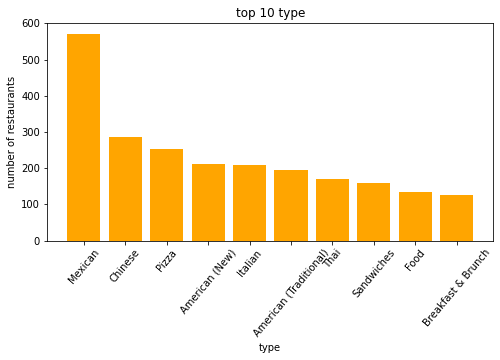

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(new_dt['type_y'].value_counts().index[0:10],new_dt['type_y'].value_counts().values[0:10],color='orange')
plt.xticks(rotation=50)
plt.xlabel('type')
plt.ylabel('number of restaurants')
plt.title('top 10 type')
plt.show()

#### 1.all the types

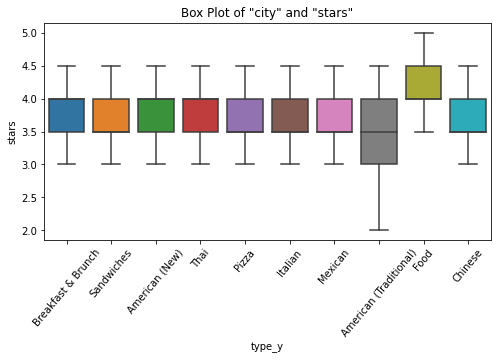

In [ ]:
plt.figure(figsize=(8,4))
new_dt_type=new_dt[new_dt.type_y.isin (new_dt['type_y'].value_counts().index[0:10].values)]
sns.boxplot(x='type_y',y='stars',data = new_dt_type, showfliers=False)
plt.title('Box Plot of "city" and "stars"')
plt.xticks(rotation=50)
plt.show()


#### 2.Mexican

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


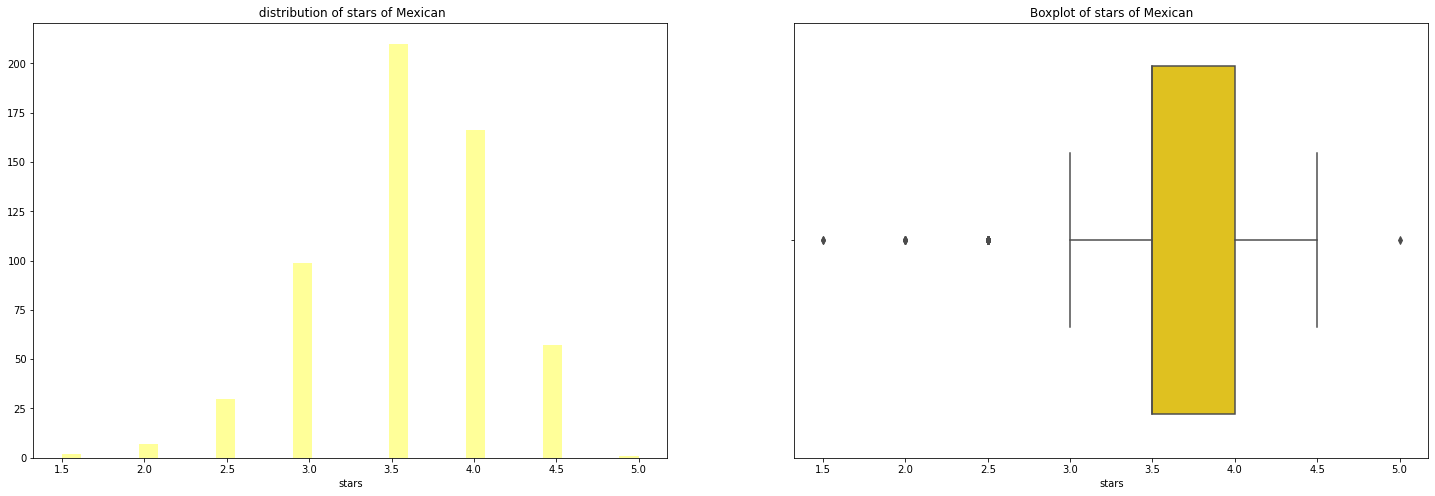

In [ ]:
Mexican=new_dt[new_dt.type_y=='Mexican']
fig, ax = plt.subplots(1,2,figsize=(25,8))
sns.distplot(Mexican.stars, kde=False,color='yellow',ax=ax[0])
sns.boxplot(x=Mexican.stars,color='gold',ax=ax[1])
ax[0].set_title(' distribution of stars of Mexican')
ax[1].set_title('Boxplot of stars of Mexican')
plt.show()

#### 3.Pizza

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


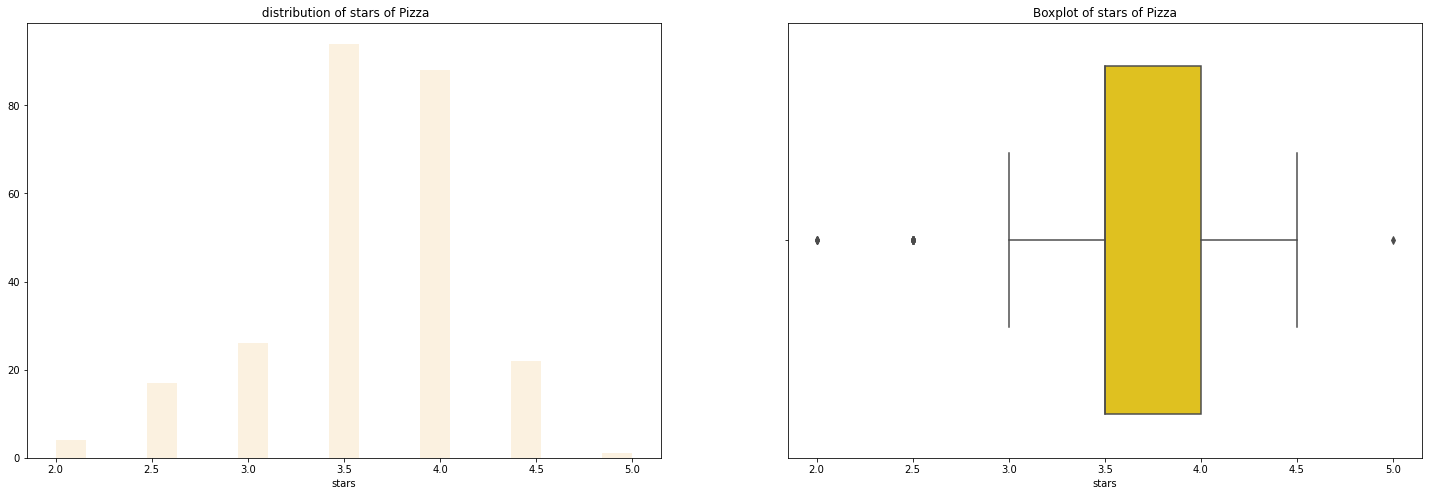

In [ ]:
Pizza=new_dt[new_dt.type_y=='Pizza']
fig, ax = plt.subplots(1,2,figsize=(25,8))
sns.distplot(Pizza.stars, kde=False,color='wheat',ax=ax[0])
sns.boxplot(x=Pizza.stars,color='gold',ax=ax[1])
ax[0].set_title(' distribution of stars of Pizza')
ax[1].set_title('Boxplot of stars of Pizza')
plt.show()

# Part 4: Visualize the most frequent words in users' reviews with highest/lowest stars

In [ ]:
data_re = pd.read_csv('yelp_review.csv')
df_business = pd.read_csv('yelp_business.csv')
df2 = pd.merge(data_re, df_business, on = 'business_id', how='left')

In [ ]:
# 20 most frequent single words in star 1 ratings
from sklearn.feature_extraction.text import CountVectorizer

df2_star1 = df2[df2['stars_y'] == 1.0]
X1_text = df2_star1['text']

vec = CountVectorizer(ngram_range=(1,1),stop_words = 'english').fit(X1_text)
X_words = vec.transform(X1_text)    
sum_words = X_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]     
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
ls1_star1 = words_freq[:20]

df1_star1 = pd.DataFrame(ls1_star1)
df1_star1.columns = ['word', 'word count']
df1_star1

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (14,8))
plt.bar("word", "word count", data = df1_star1)
plt.xlabel("Word")
plt.ylabel("Word Frequency")
plt.xticks(rotation=45)
plt.title("20 most frequent words in the star 1 reviews")

In [ ]:
# Insert the image for reference
from google.colab import drive
drive.mount('/content/drive/')

from google.colab import files
uploaded = files.upload()
from IPython.display import Image

Mounted at /content/drive/


Saving p4-1.png to p4-1.png


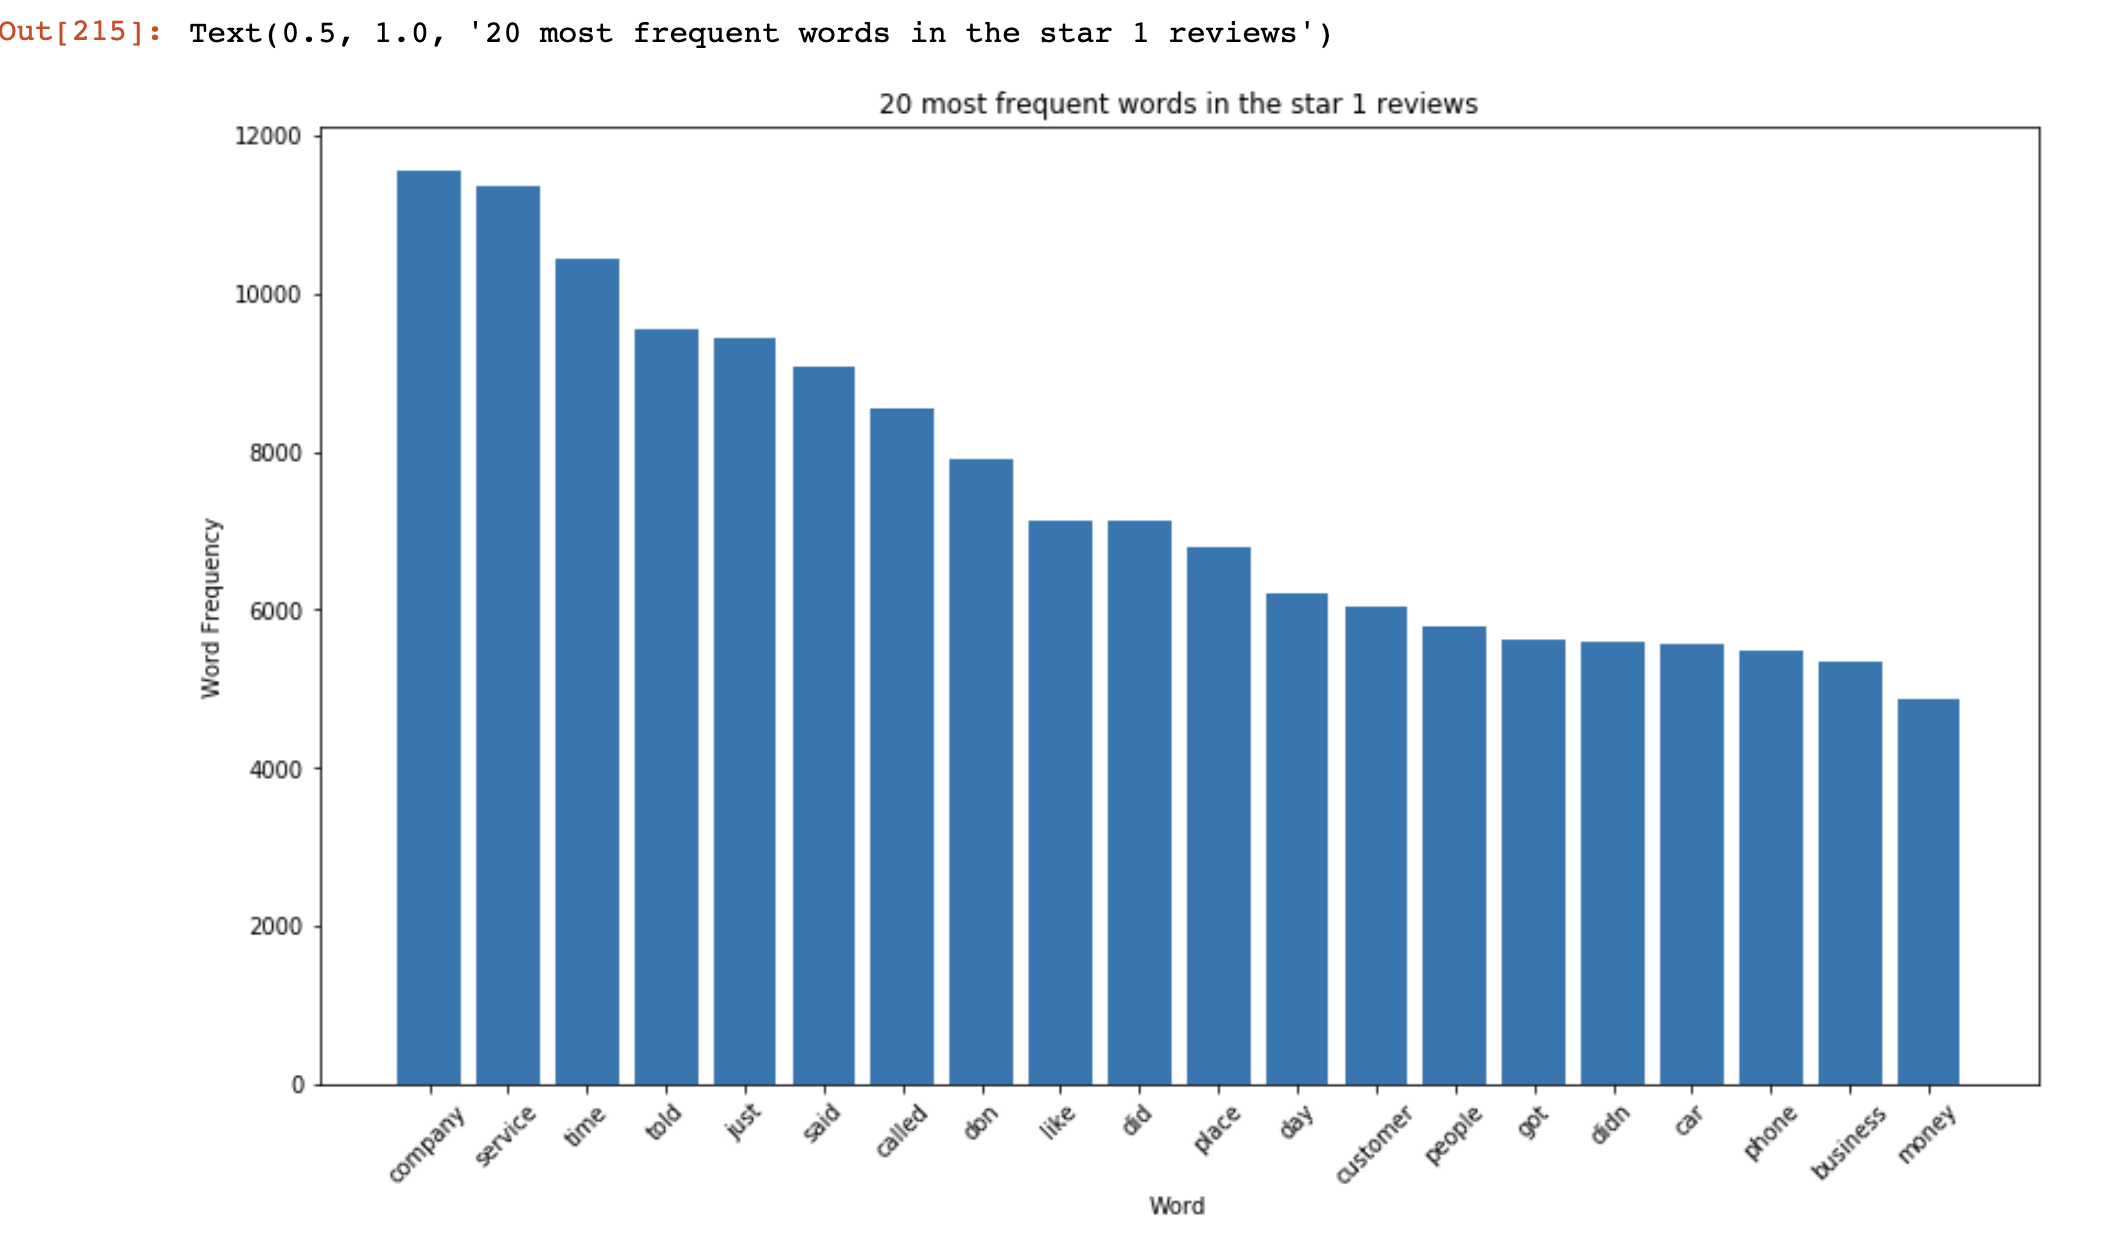

In [ ]:
# Image for reference
Image('p4-1.png')

In [ ]:
# 20 most frequent bigrams in star 1 ratings

vec = CountVectorizer(ngram_range=(2,2),stop_words = 'english').fit(X1_text)
X_words = vec.transform(X1_text)    
sum_words = X_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]     
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
ls2_star1 = words_freq[:20]

df2_star1 = pd.DataFrame(ls2_star1)
df2_star1.columns = ['word', 'word count']
df2_star1

In [ ]:
plt.figure(figsize = (14,8))
plt.bar("word", "word count", data = df2_star1)
plt.xlabel("Bigrams")
plt.ylabel("Word Frequency")
plt.xticks(rotation=45)
plt.title("20 most frequent bigrams in the star 1 reviews")

In [ ]:
# Insert image for reference
from google.colab import files
uploaded = files.upload()
from IPython.display import Image

Saving p4-2.png to p4-2.png


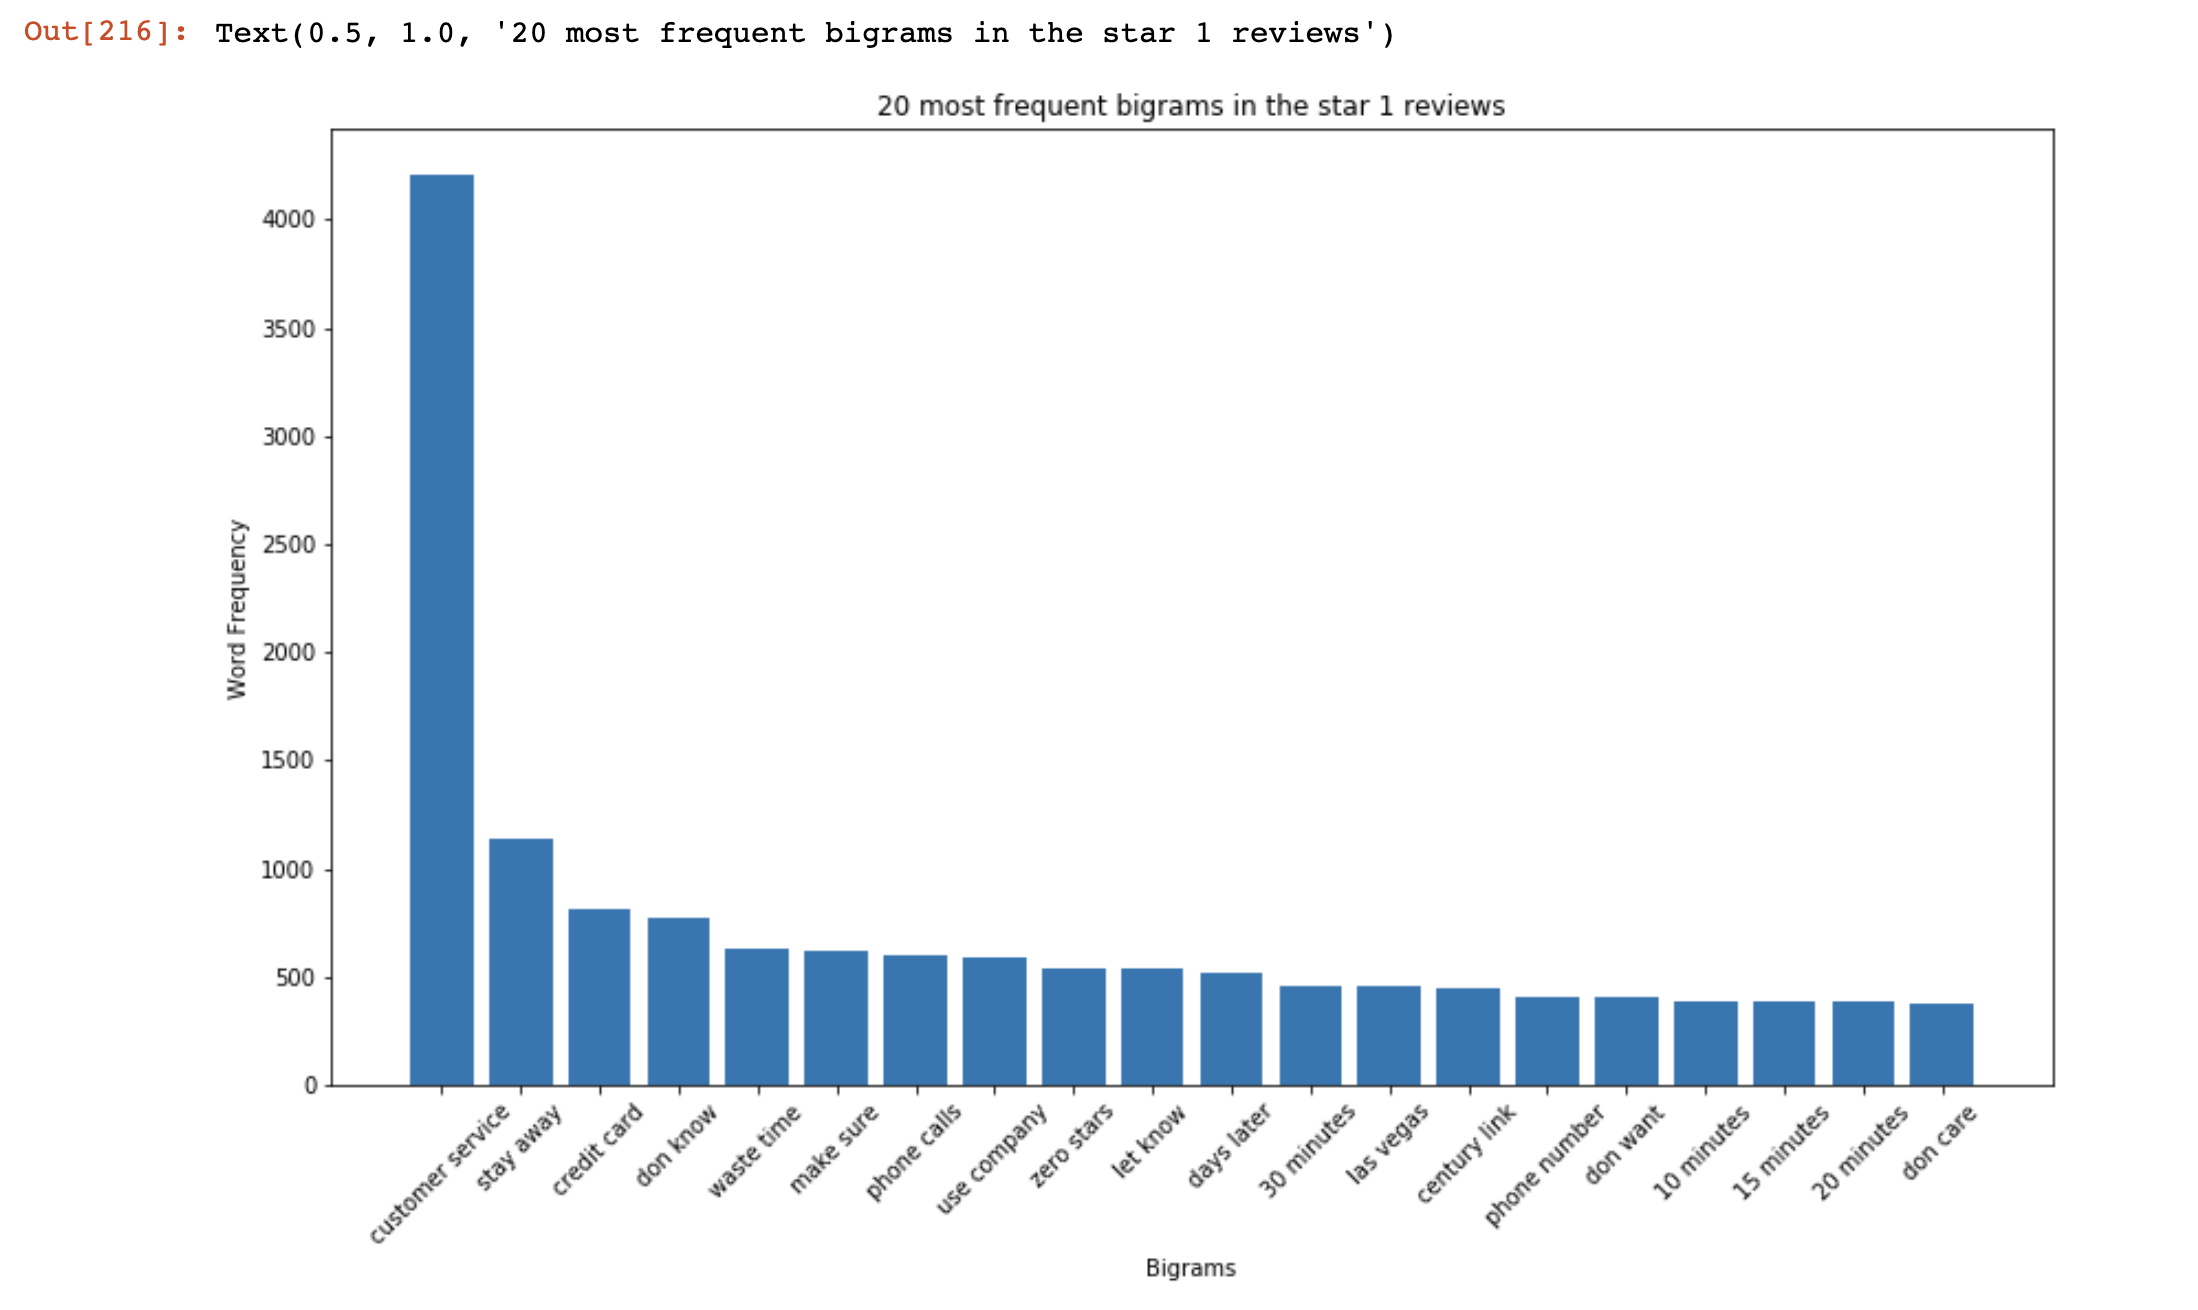

In [ ]:
# Image for reference
Image('p4-2.png')

In [ ]:
# 20 most frequent single words in star 5 ratings
df2_star5 = df2[df2['stars_y'] == 5.0]
X5_text = df2_star5['text']

vec = CountVectorizer(ngram_range=(1,1),stop_words = 'english').fit(X5_text)
X_words = vec.transform(X5_text)    
sum_words = X_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]     
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
ls1_star5 = words_freq[:20]

df1_star5 = pd.DataFrame(ls1_star5)
df1_star5.columns = ['word', 'word count']
df1_star5

In [ ]:
plt.figure(figsize = (14,8))
plt.bar("word", "word count", data = df1_star5)
plt.xlabel("Words")
plt.ylabel("Word Frequency")
plt.xticks(rotation=45)
plt.title("20 most frequent words in the star 5 reviews")

In [ ]:
# Insert Image for reference
from google.colab import files
uploaded = files.upload()
from IPython.display import Image

Saving p4-3.png to p4-3.png


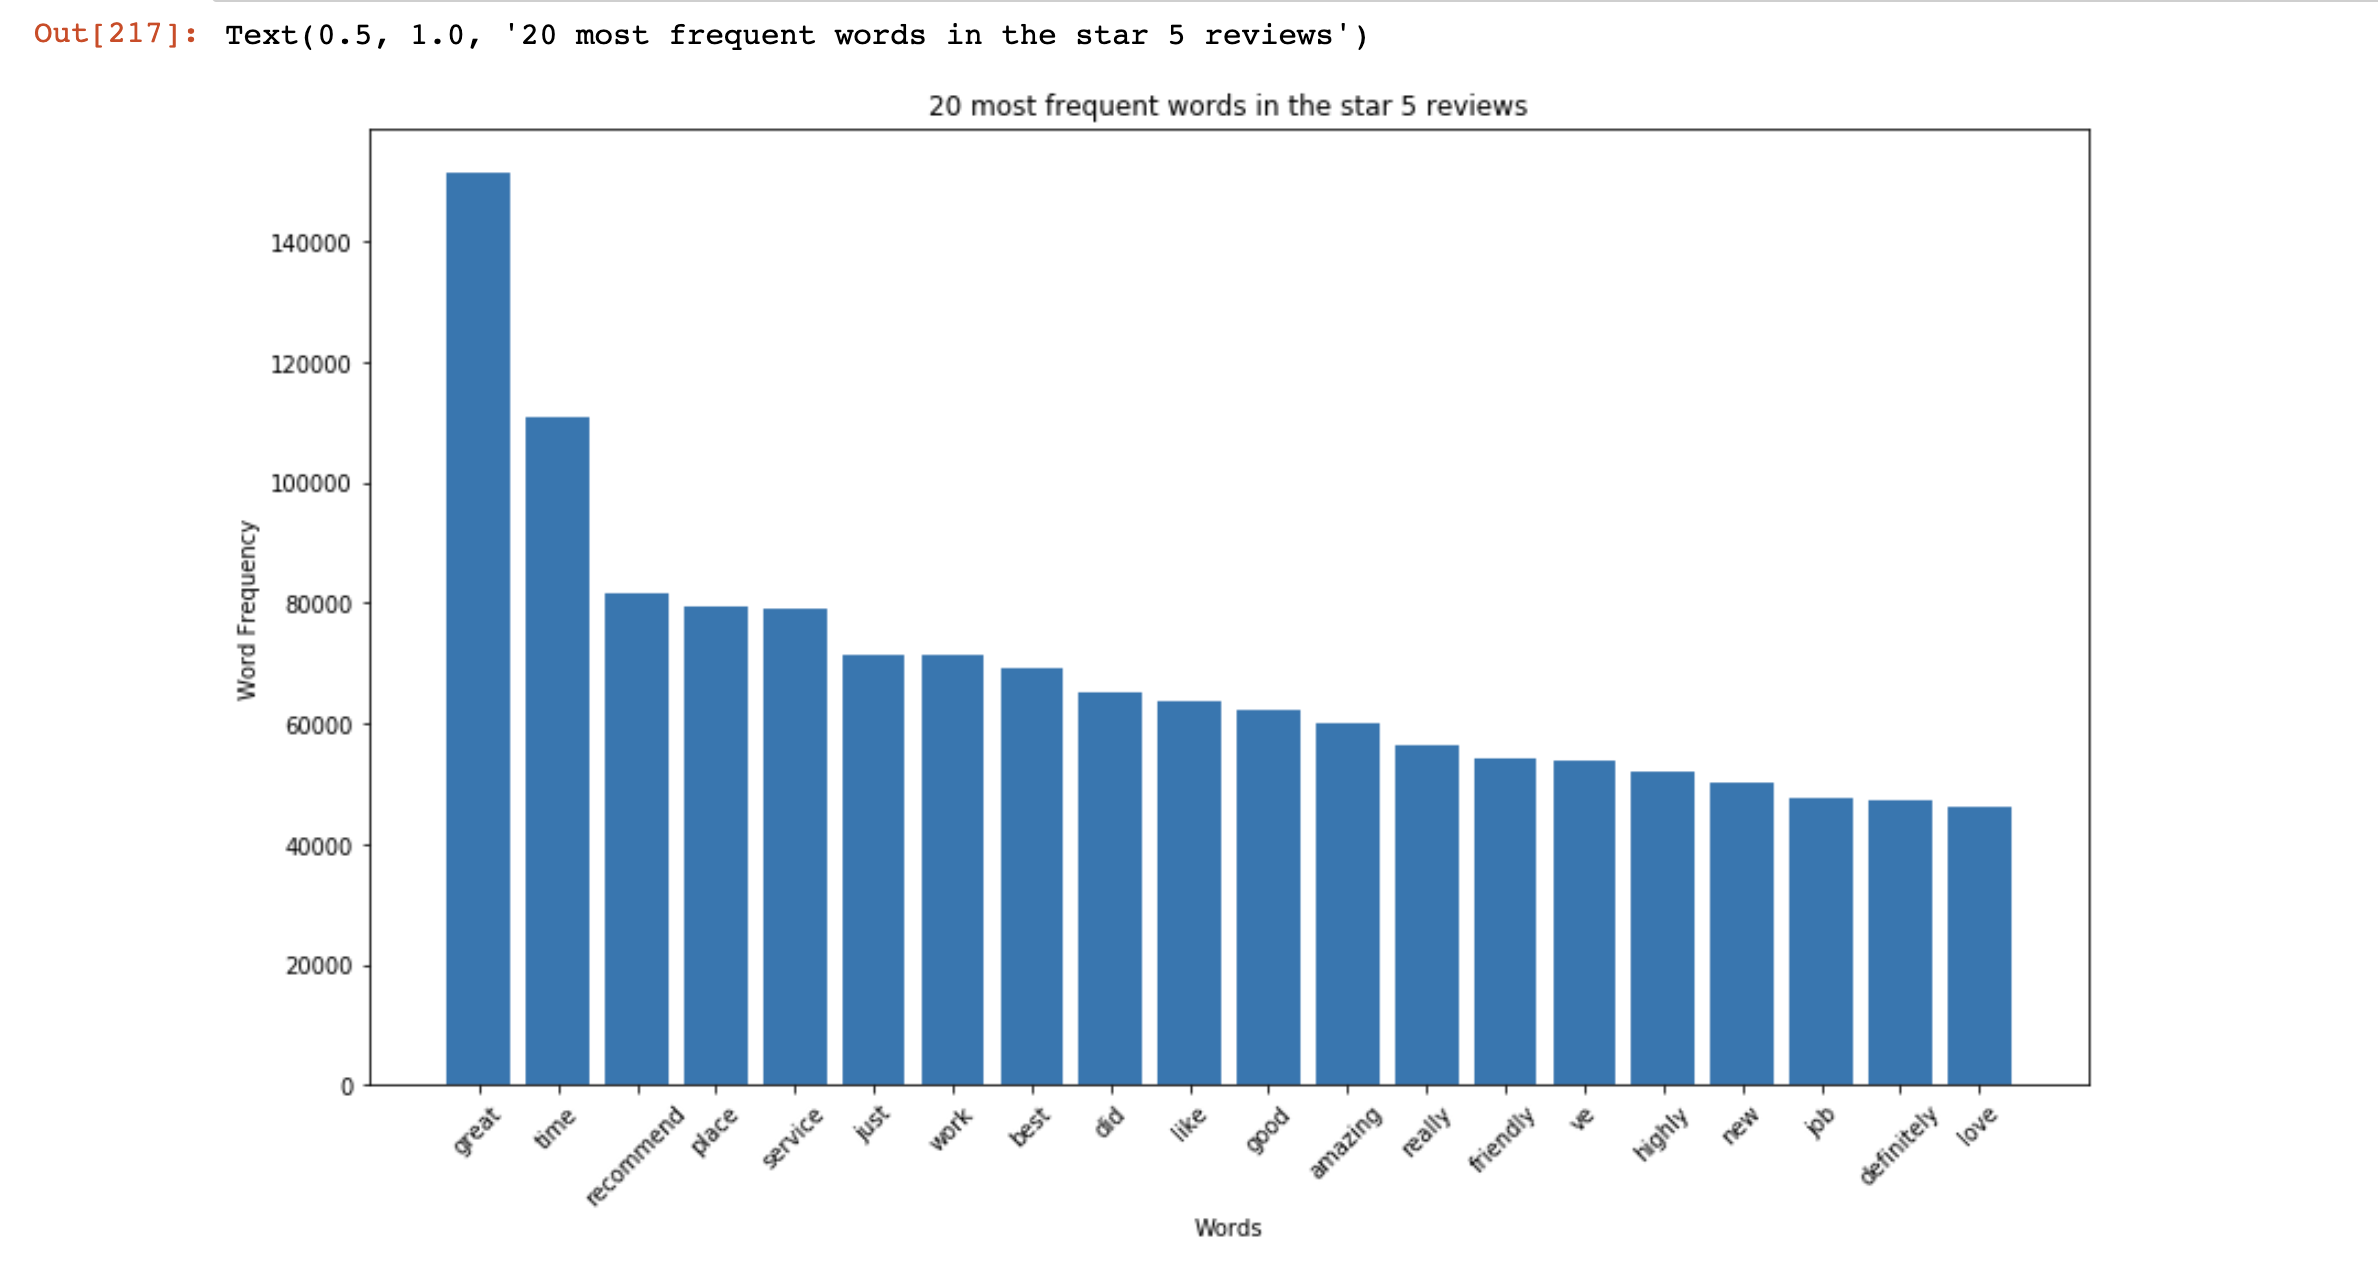

In [ ]:
# Image for reference
Image('p4-3.png')

In [ ]:
# 20 most frequent bigrams in star 5 ratings

vec = CountVectorizer(ngram_range=(2,2),stop_words = 'english').fit(X5_text)
X_words = vec.transform(X5_text)    
sum_words = X_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]     
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
ls2_star5 = words_freq[:20]

df2_star5 = pd.DataFrame(ls2_star5)
df2_star5.columns = ['word', 'word count']
df2_star5

In [ ]:
plt.figure(figsize = (14,8))
plt.bar("word", "word count", data = df1_star5)
plt.xlabel("Bigrams")
plt.ylabel("Word Frequency")
plt.xticks(rotation=45)
plt.title("20 most frequent bigrams in the star 5 reviews")

In [ ]:
# Insert image for reference
from google.colab import files
uploaded = files.upload()
from IPython.display import Image

Saving p4-4.png to p4-4.png


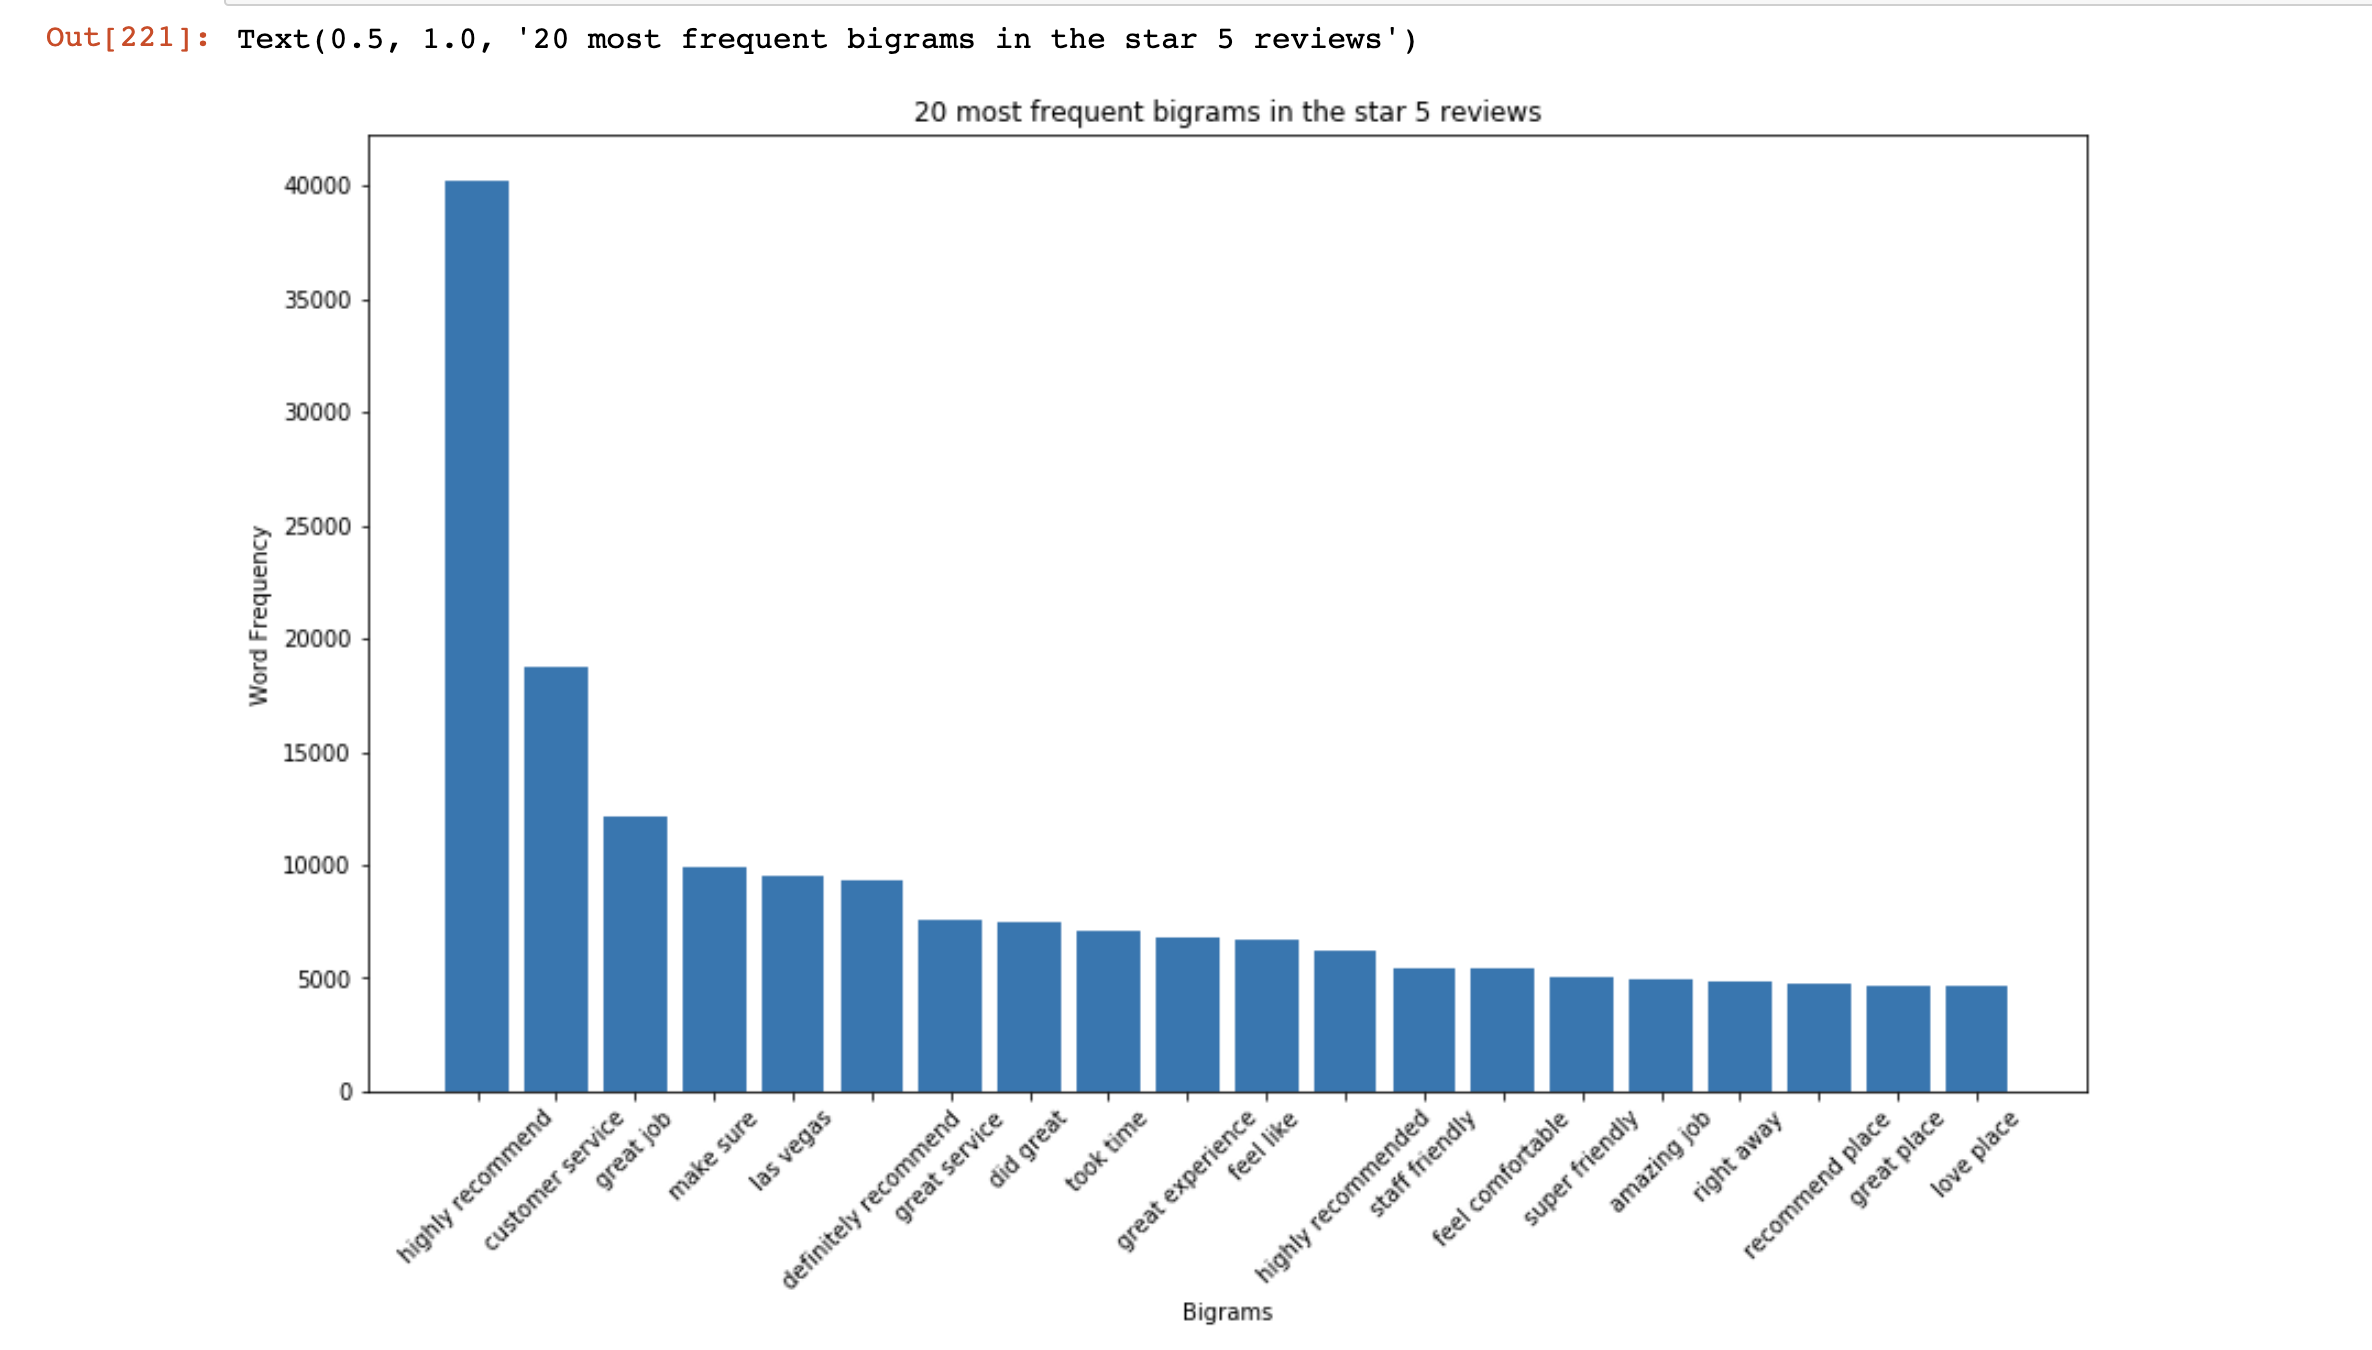

In [ ]:
# Image for reference
Image('p4-4.png')

# Part 5: Most frequent words in reviews from different types of restaurants

In [ ]:
df5 = pd.merge(data_re, business_type, left_on='business_id', right_index=True, how='left')

In [ ]:
r_types = set(new_dt['type_y'])

output types: {'American (New)',
 'American (Traditional)',
 'Asian Fusion',
 'Barbeque',
 'Breakfast & Brunch',
 'Burgers',
 'Chinese',
 'Diners',
 'Fast Food',
 'Food',
 'Greek',
 'Indian',
 'Italian',
 'Japanese',
 'Korean',
 'Mediterranean',
 'Mexican',
 'Middle Eastern',
 'Nightlife',
 'Pakistani',
 'Pizza',
 'Sandwiches',
 'Seafood',
 'Sushi Bars',
 'Thai',
 'Vegetarian',
 'Vietnamese',
 nan}

In [ ]:
df_chinese = df5[df5['type'] == 'Chinese']
X5_chinese = df2_star5['text']

vec = CountVectorizer(ngram_range=(1,1),stop_words = 'english').fit(X5_chinese)
X_words = vec.transform(X5_text)    
sum_words = X_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]     
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
ls5_chinese = words_freq[:20]

df5_chinese = pd.DataFrame(ls5_chin)
df5_chinese.columns = ['word', 'word count']
df5_chinese

In [ ]:
plt.figure(figsize = (14,8))
plt.bar("word", "word count", data = df5_chinese)
plt.xlabel("words")
plt.ylabel("Word Frequency")
plt.xticks(rotation=45)
plt.title("20 most frequent words in the reviews of Chinese restaurants")